# Project: Sentiment Analysis of Bank Customer Reviews using Bidirectional Encoder Representations from Transformers

## Basic information
- Course: CS583 - Deep Learning
- Student name: Thanapoom Phatthanaphan
- Student CWID: 20011296

## Introduction
In the ever-evolving landscape of the banking industry, the invaluable role of customer feedback cannot be overstated. In an era dominated by digital communication, customer reviews and textual comments wield a considerable influ-ence over consumer choices, shaping the overall reputation and performance of financial institutions. The multifaceted nature of language and the sheer volume of textual data, however, present a formidable challenge when attempting to extract meaningful insights from these reviews.
This research embarks on a pioneering journey to navigate this challenge by adopting a sophisticated approach to sen-timent analysis. The traditional methods of sentiment analysis fall short when faced with the complexity and nu-ance inherent in customer reviews. To overcome these limi-tations, we embrace cutting-edge technologies, specifically Bidirectional Encoder Representations from Transformers (BERT) with PyTorch.
The central objective of this research is to construct an ad-vanced sentiment analysis system that goes beyond mere classification of customer reviews as positive or negative. We delve into the nuances of customer sentiments and preferences, aiming to unravel the intricate layers of feed-back intricately woven into the vast tapestry of textual da-ta. This ambitious project focuses on a substantial dataset comprising 10,000 recent customer reviews sourced from 48 diverse banks across the United States.
The integration of BERT embeddings with PyTorch signi-fies a departure from conventional sentiment analysis methods. BERT, known for its contextual understanding of language, enhances the model's ability to capture subtle-ties within the reviews, surpassing the limitations of tradi-tional methods. The primary goal is not merely to catego-rize reviews but to provide the banking industry with nu-anced and precise insights into customer sentiments. By leveraging the power of BERT embeddings with PyTorch, we aim to overcome the challenges inherent in textual feedback analysis and elevate the analysis to a level where it becomes a strategic tool for enhancing service quality. This research aspires to empower the banking industry, of-fering actionable insights that transcend the binary classifi-cation of positive or negative sentiments. The vision ex-tends beyond classification; it encompasses a comprehen-sive understanding of the underlying sentiments and prefer-ences expressed by customers. Ultimately, this endeavor seeks to catalyze a paradigm shift in how the banking in-dustry interprets and responds to customer feedback, foster-ing an environment of continuous improvement and heightened customer satisfaction.

## Dataset
The dataset utilized in this research comprises over 10,000 customer reviews sourced from 48 distinct banking institu- tions within the United States. This publicly available dataset can be accessed through the Kaggle community platform, offering a comprehensive collection of customer sentiments towards various banks. The dataset's primary objective is to serve as a resource for training and evaluating the sentiment analysis system proposed in this research. For easy accessibility, the dataset can be downloaded using the following link: https://www.kaggle.com/datasets/trainingdatapro/20000-customers-reviews-on-banks/data. The richness of this dataset not only allows for a detailed exploration of customer feedback but also ensures a diverse and representative sample, crucial for the effectiveness and generalizability of the sentiment analysis model.

## Goal
Building the sentiment analysis using BERT to analyze each customer review to judge that it is positive or negative review, considering 4-5 stars as positive reviews and 1-3 stars as negative reviews.

In [1]:
# Import the necessary libraries for performing data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import necessary libraries for cleaning text
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import re

# Install the required libraries for BERT
!pip install transformers
!pip install torch

# Import the necessary libraries for BERT
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time
from prettytable import PrettyTable

# Import the necessary libraries for evaluation
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Importing the dataset
Import the dataset of customer reviews from 48 distinct banks across the United States.

In [2]:
# Allow access to google drive where
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import the dataset
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Banks.csv')
data

,author,date,location,bank,star,text,like
0,Kyle,31.08.2023,"Magnolia, TX",merrick_bank,5,Very easy to use to view statements and make o...,NaN
1,Julicia,23.08.2023,"Columbus, GA",merrick_bank,5,Merrick Bank has always been good to me for bu...,NaN
2,Karen,2.06.2023,"Marrero, LA",merrick_bank,4,Times are tough for everyone and I have worked...,3.0
3,Brent,29.03.2023,"Moultrie, GA",merrick_bank,5,I can not asked for a better Credit Card Compa...,3.0
4,Sharon,23.11.2022,"Burnham, IL",merrick_bank,5,Updated on 02/10/2023: I was happy to sign for...,3.0
...,...,...,...,...,...,...,...
19266,J.,30.01.2017,"Salem, OR",tcf_bank,1,Paid my 1st payment on time. They sent me a la...,11.0
19267,Destiny,28.01.2017,"Andover, MN",tcf_bank,1,I have banked with TCF for about 4 years now a...,12.0
19268,Sean,25.01.2017,"Bothell, WA",tcf_bank,1,Most inconvenient bank ever. As a business own...,10.0
19269,Edgar,12.01.2017,"Minneapolis, MI",tcf_bank,1,Well I've been with TCF Bank for 3 plus years ...,12.0


## 2. Data Preprocessing

- Add a sentiment column indicating positive and negative reviews based on a specified criteria (e.g., 4-5 stars as positive, 1-3 stars as negative).
- Remove punctuations and numbers from the text.
- Convert the text into lowercase for uniformity.

In [4]:
# Let's check for missing values
data.isnull().sum()

author         1
date           0
location       0
bank           0
star           0
text          90
like        1502
dtype: int64

In [5]:
# Delete rows that contain missing values
data = data.dropna(subset=['text'])

In [6]:
# Recheck for missing values
data.isnull().sum()

author         1
date           0
location       0
bank           0
star           0
text           0
like        1496
dtype: int64

In [7]:
# Consider 4-5 star reviews as positive reviews (1) and 1-3 star reviews as negative reviews (0)
reviews_data = data[['star', 'text']]
reviews_data['sentiment'] = reviews_data['star'].apply(lambda x: 0 if x <= 3 else 1)
reviews_data

<ipython-input-7-f676d0e68b29>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['sentiment'] = reviews_data['star'].apply(lambda x: 0 if x <= 3 else 1)


,star,text,sentiment
0,5,Very easy to use to view statements and make o...,1
1,5,Merrick Bank has always been good to me for bu...,1
2,4,Times are tough for everyone and I have worked...,1
3,5,I can not asked for a better Credit Card Compa...,1
4,5,Updated on 02/10/2023: I was happy to sign for...,1
...,...,...,...
19266,1,Paid my 1st payment on time. They sent me a la...,0
19267,1,I have banked with TCF for about 4 years now a...,0
19268,1,Most inconvenient bank ever. As a business own...,0
19269,1,Well I've been with TCF Bank for 3 plus years ...,0


**Clean the text**

In [8]:
# Function to clean the text
def clean_text(text):

    """ A function to clean the text """

    # Convert all text to lowercase to ensure uniformity
    text = str(text).lower()

    # Remove punctuations, and numbers
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\d', '', text)

    # Create a set of stopwords
    stop_words = set(stopwords.words('english'))

    # Tokenize the text into words
    words = tokenization(text)
    cleaned_text = ''
    for word in words:

        # Get the token excludes those stopwords
        if word not in stop_words:
            cleaned_text += ' ' + word

    return cleaned_text


# Function to tokenize the text
def tokenization(text):

    """ A function to tokenize the text """

    words = nltk.word_tokenize(text)

    return words


# Call the function to clean and tokenize the text.
reviews_data['text'] = reviews_data['text'].apply(clean_text)
reviews_data

<ipython-input-8-b06ce47722c8>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['text'] = reviews_data['text'].apply(clean_text)


,star,text,sentiment
0,5,easy use view statements make online payments...,1
1,5,merrick bank always good business rely merric...,1
2,4,times tough everyone worked hard get credit r...,1
3,5,asked better credit card company merrick bank...,1
4,5,updated happy sign new credit card merrick co...,1
...,...,...,...
19266,1,paid st payment time sent late notice stating...,0
19267,1,banked tcf years first bank account ever past...,0
19268,1,inconvenient bank ever business owner many ba...,0
19269,1,well ive tcf bank plus years never issue ive ...,0


**Data statistics**

In [9]:
# Get the number of tokens
def get_num_tokens(tokens_list):

    """A function to get the number of tokens"""

    return len(tokens_list)

# Calculate basic statistics of the data
dataset_info = {
    'Sentiment': ['Positive reviews',
                  'Negative reviews'],
    '#Reviews': [len(reviews_data[reviews_data['sentiment'] == 1]['text']),
                 len(reviews_data[reviews_data['sentiment'] == 0]['text'])],
    'Min. #tokens': [min(reviews_data[reviews_data['sentiment'] == 1]['text'].apply(get_num_tokens)),
                     min(reviews_data[reviews_data['sentiment'] == 0]['text'].apply(get_num_tokens))],
    'Avg. #tokens': [round(reviews_data[reviews_data['sentiment'] == 1]['text'].apply(get_num_tokens).mean()),
                     round(reviews_data[reviews_data['sentiment'] == 0]['text'].apply(get_num_tokens).mean())],
    'Max. #tokens': [max(reviews_data[reviews_data['sentiment'] == 1]['text'].apply(get_num_tokens)),
                     max(reviews_data[reviews_data['sentiment'] == 0]['text'].apply(get_num_tokens))]
}

# Create a DataFrame that contains the statistics of the data
dataset_info_table = pd.DataFrame(dataset_info)

# Print the statistics table
dataset_info_table

,Sentiment,#Reviews,Min. #tokens,Avg. #tokens,Max. #tokens
0,Positive reviews,1869,8,212,643
1,Negative reviews,17312,6,349,1071


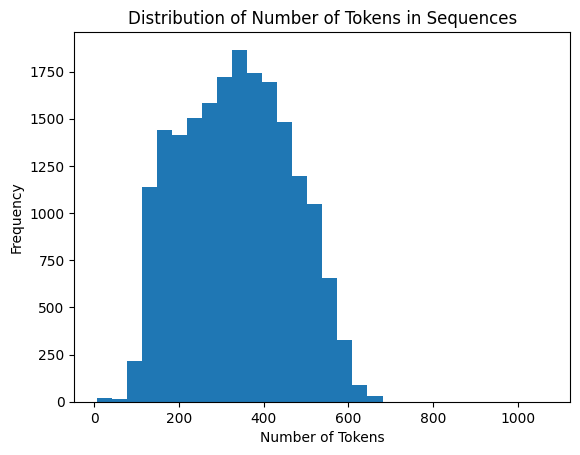

In [10]:
# Plot the bar chart to see the distribution of the number of tokens
sequence_lengths = [reviews_data['text'].apply(get_num_tokens)]
plt.hist(sequence_lengths, bins=30)
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Tokens in Sequences')
plt.show()

## 3. Tokenization and Model Training
Systematically divided into three sets: training (80%), validation (10%), and test (10%). Training set instructs the BERT model, enabling it to learn patterns and relationships within the data. Validation set is crucial for fine-tuning the model, experimenting with hyperparameter configurations. Test set is for evaluating the model performance.

**Split the datset into 3 parts: Training set, Valiation set, Test set**

In [11]:
# Define input variable and target variable
reviews = pd.DataFrame(reviews_data['text'])
labels = pd.DataFrame(reviews_data['sentiment'])

# Split the dataset into 3 parts, including training set (80%), validation set (10%), and test set (10%)
reviews_train, reviews_temp, labels_train, labels_temp = train_test_split(reviews, labels, test_size=0.2, random_state=100)
reviews_val, reviews_test, labels_val, labels_test = train_test_split(reviews_temp, labels_temp, test_size=0.5, random_state=100)

In [12]:
reviews

,text
0,easy use view statements make online payments...
1,merrick bank always good business rely merric...
2,times tough everyone worked hard get credit r...
3,asked better credit card company merrick bank...
4,updated happy sign new credit card merrick co...
...,...
19266,paid st payment time sent late notice stating...
19267,banked tcf years first bank account ever past...
19268,inconvenient bank ever business owner many ba...
19269,well ive tcf bank plus years never issue ive ...


In [13]:
labels

,sentiment
0,1
1,1
2,1
3,1
4,1
...,...
19266,0
19267,0
19268,0
19269,0


**Tokenize and encode the data using the BERT tokenizer**

In [14]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the sentences for the training set, validation set, and test set
max_len = 256
train_encodings = tokenizer(reviews_train['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
val_encodings = tokenizer(reviews_val['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
test_encodings = tokenizer(reviews_test['text'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Convert sentiment labels to PyTorch tensors
train_labels = torch.tensor(labels_train['sentiment'].tolist())
val_labels = torch.tensor(labels_val['sentiment'].tolist())
test_labels = torch.tensor(labels_test['sentiment'].tolist())

In [15]:
train_encodings

{'input_ids': tensor([[  101,  5223, 12978,  ...,     0,     0,     0],
        [  101,  2034,  5741,  ...,     0,     0,     0],
        [  101,  1052, 12273,  ...,     0,     0,     0],
        ...,
        [  101,  2288,  4003,  ...,     0,     0,     0],
        [  101,  4162,  3784,  ...,     0,     0,     0],
        [  101, 10263,  3361,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

**Create DataLoader**

In [16]:
# Define datasets using TensorDataset, containing input_ids, attention_mask, and labels
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# Define batch size
batch_size = 32

# Create DataLoader for training set , validation set, and test set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Load Pre-trained BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Fine-Tuning BERT model using Validation Set**

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Training Loss: 0.15597056420519947, Validation Accuracy: 0.9718456725755996
Training Time for Epoch 1: 129.44 seconds
Max GPU Memory Allocated: 5745.69 MB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:329: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Epoch 2/3, Training Loss: 0.07650929606170394, Validation Accuracy: 0.9718456725755996
Training Time for Epoch 2: 129.41 seconds
Max GPU Memory Allocated: 5748.17 MB
Epoch 3/3, Training Loss: 0.0450174947368699, Validation Accuracy: 0.9708029197080292
Training Time for Epoch 3: 129.37 seconds
Max GPU Memory Allocated: 5744.78 MB


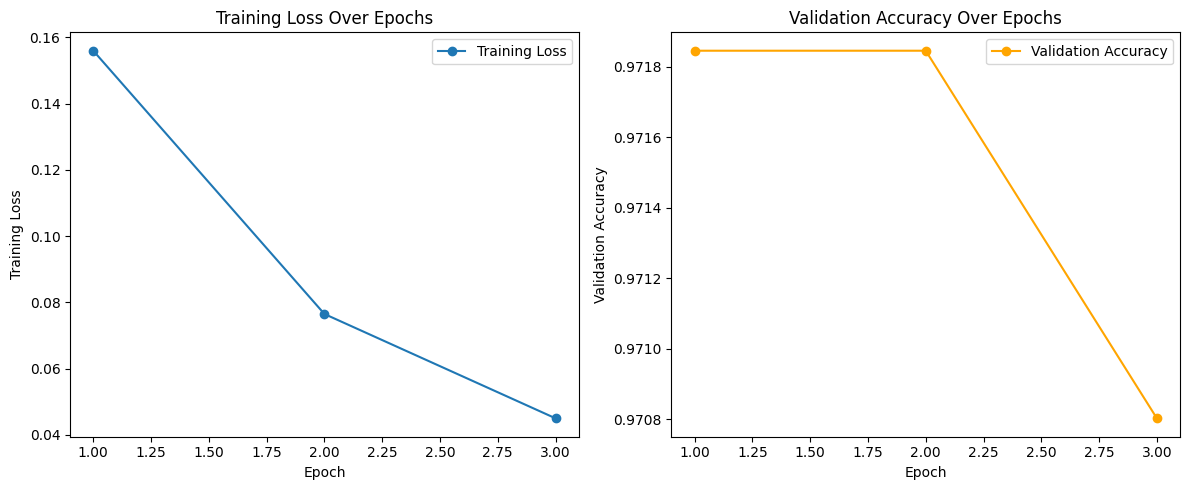

+-------+---------------------+---------------------+--------------------+-------------------------------+
| Epoch |    Training Loss    | Validation Accuracy | Training Time (s)  | Max GPU Memory Allocated (MB) |
+-------+---------------------+---------------------+--------------------+-------------------------------+
|   1   | 0.15597056420519947 |  0.9718456725755996 | 129.43725109100342 |           5745.6875           |
|   2   | 0.07650929606170394 |  0.9718456725755996 | 129.4111795425415  |        5748.1650390625        |
|   3   |  0.0450174947368699 |  0.9708029197080292 | 129.37072157859802 |        5744.7822265625        |
+-------+---------------------+---------------------+--------------------+-------------------------------+


In [18]:
# Move the model to the appropriate device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer (AdamW) with a learning rate of 2e-5
optimizer = AdamW(model.parameters(), lr=2e-5)

# Lists to store values for plotting
train_loss_values = []
val_accuracy_values = []
training_times = []
memory_allocated_values = []

# Initialize a PrettyTable
table = PrettyTable()
table.field_names = ["Epoch", "Training Loss", "Validation Accuracy", "Training Time (s)", "Max GPU Memory Allocated (MB)"]

# Number of training epochs
num_epochs = 3

# Loop through each epoch
for epoch in range(num_epochs):

    # Record the start time
    start_time = time.time()

    # Set the model to training mode and initialize total loss for the epoch
    model.train()
    total_loss = 0.0

    # Loop through the training data in batches
    for batch in train_loader:

        # Move input data to the appropriate device
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Zero the gradients to prevent accumulation from previous batches
        optimizer.zero_grad()

        # Forward pass: calculate model predictions and compute the loss
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = F.cross_entropy(outputs.logits, labels)
        total_loss += loss.item()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Optimization step: update model parameters using the optimizer
        optimizer.step()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Record the end time
    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time

    # Set the model to evaluation mode to evaluate the performance of each epoch
    model.eval()

    # Initialize total correct predictions and total samples for validation
    total_correct = 0
    total_samples = 0

    # Disable gradient computation during validation
    with torch.no_grad():

        # Loop through the validation data in batches
        for batch in val_loader:

            # Move input data to the appropriate device
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            # Forward pass: calculate model predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            # Update total correct predictions and total samples
            total_correct += torch.sum(predictions == labels).item()
            total_samples += labels.size(0)

    # Calculate validation accuracy
    accuracy = total_correct / total_samples

    # Record the end time
    end_time = time.time()

    # Check GPU memory (MB)
    max_memory_allocated = torch.cuda.max_memory_allocated() / 1024 ** 2

    # Print result of the epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_loss}, Validation Accuracy: {accuracy}')
    print(f'Training Time for Epoch {epoch + 1}: {training_time:.2f} seconds')
    print(f'Max GPU Memory Allocated: {max_memory_allocated:.2f} MB')

    # Add values to the lists for plotting
    train_loss_values.append(average_loss)
    val_accuracy_values.append(accuracy)
    training_times.append(training_time)
    memory_allocated_values.append(max_memory_allocated)

    # Add the results to the PrettyTable
    table.add_row([epoch + 1, average_loss, accuracy, training_time, max_memory_allocated])

    # Reser GPU memory statistics
    torch.cuda.reset_max_memory_allocated()

# Plotting the graphs
epochs_range = range(1, num_epochs + 1)

# Set the size of the graph
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_values, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracy_values, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Print the table
print(table)

## 4. Classification and Evaluation
Evaluate the model performance to classify the reviews between positive and negative reviews on Test dataset.

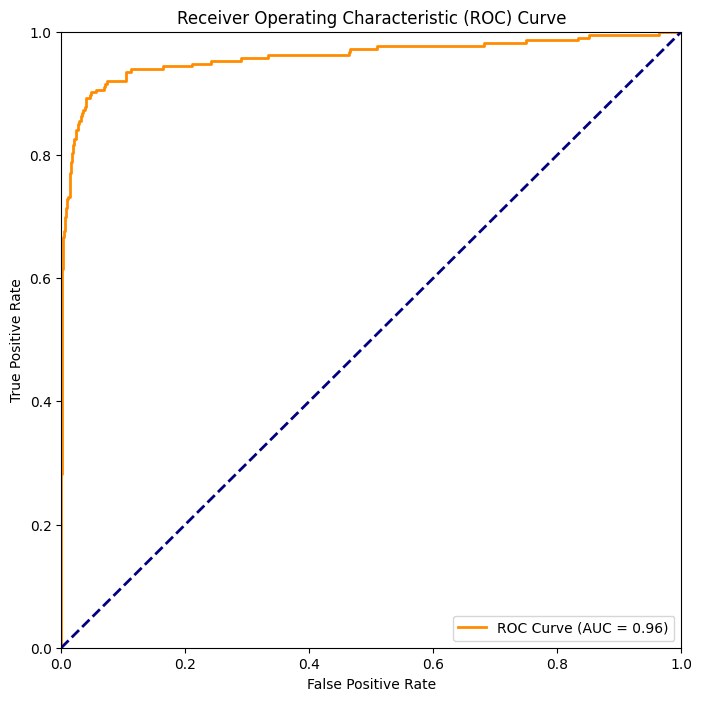

ROC-AUC Score: 0.9601
Accuracy: 0.9620


In [19]:
# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []
predicted_labels = []

# Evaluate the Model on the Test Set
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)[:, 1]
        predictions = torch.argmax(logits, dim=1)

        # Collect true labels and predicted probabilities
        true_labels.extend(labels.cpu().numpy())
        predicted_probs.extend(probabilities.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(true_labels, predicted_probs)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print ROC-AUC Score and Accuracy
print(f'ROC-AUC Score: {roc_auc:.4f}')
print(f'Accuracy: {accuracy:.4f}')

**Manual evaluation**

In [20]:
# 10 unseen reviews for manual test
unseen_reviews = ["Impressed with the bank's online services, making transactions has never been easier.",
                  "Customer support was unhelpful and frustrating; it took forever to resolve a simple issue.",
                  "Received a great interest rate on my savings account, very satisfied with the banking experience.",
                  "The mobile app is user-friendly and convenient for managing accounts on the go.",
                  "Unexpected fees and hidden charges made my experience with this bank disappointing.",
                  "Quick and efficient loan approval process, would recommend for financial assistance.",
                  "The staff at the local branch were friendly and assisted me with professionalism.",
                  "I've been a customer for years, and the bank has consistently met my financial needs.",
                  "The credit card application process was straightforward, and I got approved quickly.",
                  "Poor security measures; my account was compromised, and the recovery process was frustrating."]

# Sentiment for 10 unseen reviews
sentiment_unseen_reviews = ['Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative']

# Clean the text
cleaned_unseen_reviews = []
for text in unseen_reviews:
    cleaned_text = clean_text(text)
    cleaned_unseen_reviews.append(cleaned_text)

# Tokenize and encode the unseen reviews
unseen_encodings = tokenizer(unseen_reviews, padding=True, truncation=True, return_tensors='pt')

# Make predictions
model.eval()
with torch.no_grad():
    inputs = {key: unseen_encodings[key].to(model.device) for key in unseen_encodings}
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)

# Print the predicted sentiment for each review
i = 0
for review, prediction in zip(unseen_reviews, predictions.tolist()):
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\nTrue Sentiment: {sentiment_unseen_reviews[i]}\n")
    i += 1

Review: Impressed with the bank's online services, making transactions has never been easier.
Predicted Sentiment: Positive
True Sentiment: Positive

Review: Customer support was unhelpful and frustrating; it took forever to resolve a simple issue.
Predicted Sentiment: Negative
True Sentiment: Negative

Review: Received a great interest rate on my savings account, very satisfied with the banking experience.
Predicted Sentiment: Positive
True Sentiment: Positive

Review: The mobile app is user-friendly and convenient for managing accounts on the go.
Predicted Sentiment: Positive
True Sentiment: Positive

Review: Unexpected fees and hidden charges made my experience with this bank disappointing.
Predicted Sentiment: Negative
True Sentiment: Negative

Review: Quick and efficient loan approval process, would recommend for financial assistance.
Predicted Sentiment: Positive
True Sentiment: Positive

Review: The staff at the local branch were friendly and assisted me with professionalism.
Pr